## QAOA

Aqui vamos lidar com o problema de Max-Cut usando QAOA. 

Código baseado na referência:
- https://qiskit.org/textbook/ch-applications/qaoa.html

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize

O grafo

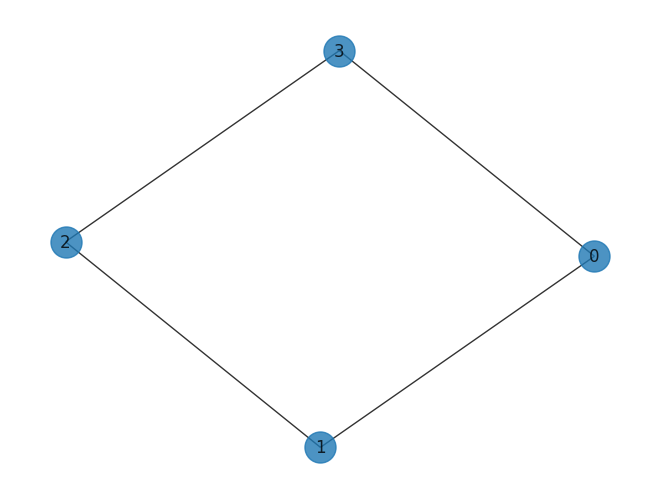

In [3]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
#Adjacência nos diz quais nós estão conectados
#A função retorna uma matriz esparsa que é convertida para uma densa
adjacency = nx.adjacency_matrix(G).todense()
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

Mixing Unitary

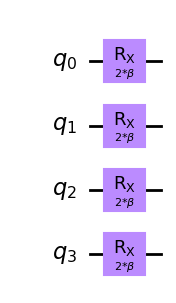

In [16]:
n_qubits = 4

beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(n_qubits)
for i in range(0, n_qubits):
    qc_mix.rx(2 * beta, i)
    
qc_mix.draw('mpl')

Problem Unitary

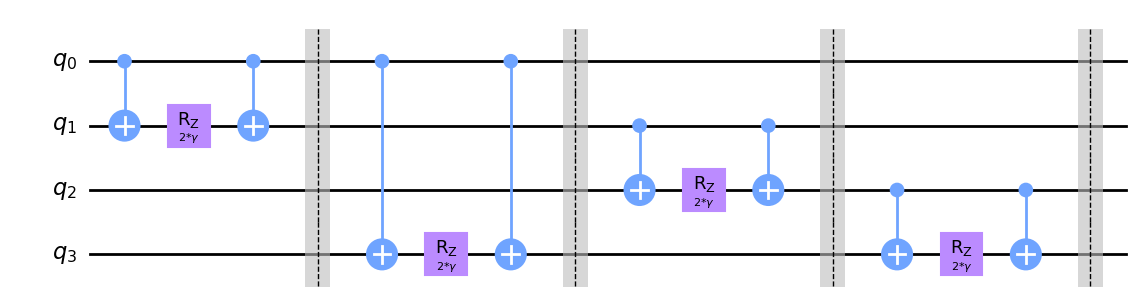

In [17]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(n_qubits)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()
    
qc_p.decompose().draw('mpl')

Estado inicial

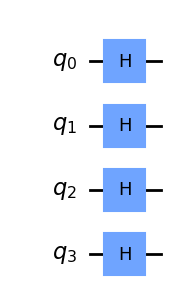

In [18]:
qc_0 = QuantumCircuit(n_qubits)
for i in range(0, n_qubits):
    qc_0.h(i)
    
qc_0.draw('mpl')

Circuito completo

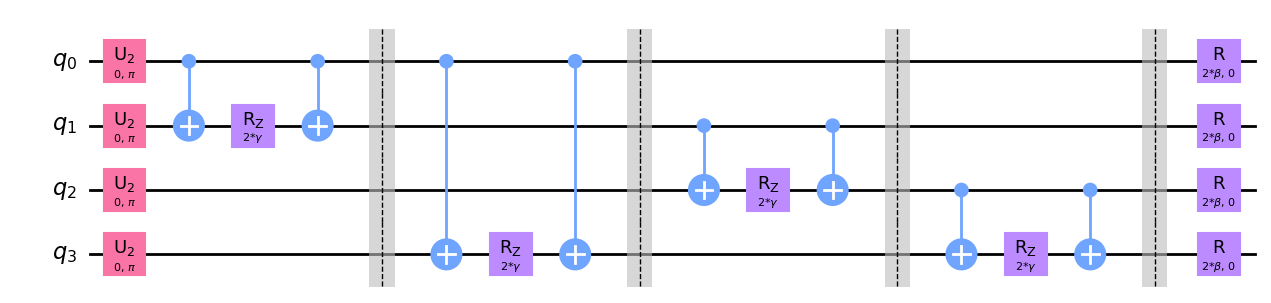

In [19]:
qc_qaoa = QuantumCircuit(n_qubits)

qc_qaoa.append(qc_0, [i for i in range(0, n_qubits)])
qc_qaoa.append(qc_p, [i for i in range(0, n_qubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, n_qubits)])

qc_qaoa.decompose().decompose().draw('mpl')

Funções utilizadas para rodar fazer medição e otimização do circuito parametrizado

In [29]:
def maxcut_obj(x, G):
    """
    Dada uma bitstring como soluçaõ, essa funçaõ retorna
    o número de arestas compartilhados entre as duas partições
    do grafo
    
    Args:
        x: str
           solução bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            obj -= 1
            
    return obj

def compute_expectation(counts, G):
    """
    Calcula o valor esperado baseado nos resultados da medição
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

def create_qaoa_circ(G, theta):
    """
    Cria o circuito QAOA parametrizado
    
    Args:  
        G: networkx graph
        theta: list
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """

    nqubits = len(G.nodes())
    #Para o nosso caso, p=1, mas vamos deixar o caso geral
    #p=Número de unitárias alternando para  os 
    #Hamiltonianos Mixer e o do Problema
    p = len(theta)//2 
    qc = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    
    for irep in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[irep], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()
        
    return qc

def get_expectation(G, shots=512):
    """
    Rodar um circuito parametrizado
    
    Args:
        G: networkx graph
        p: int,
           Número de repetições das unitárias
    """
    

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ


Agora, estamos prontos para fazer a otimizaçaõ

In [30]:
expectation = get_expectation(G)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.994140625
       x: [ 1.979e+00  1.167e+00]
    nfev: 30
   maxcv: 0.0

Vemos então que a solução ótima é $\beta=1.979$ e $\gamma=1.167$

Visualizando o resultado

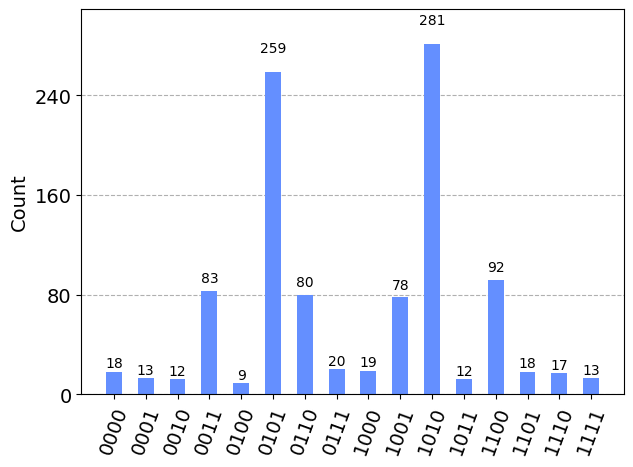

In [23]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts)

Vamos que 0101 e 1010 são bitstrings mais prováveis, que de fato correspondem às soluções ótimas do problema 